In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'ieee'])
import models

In [3]:
df = pd.read_csv('dataset.csv', index_col=0)
df.head()   

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [4]:
# Transforming track_genre column into categorical
df['track_genre'] = df['track_genre'].astype('category')
df['key'] = df['key'].astype('category')
df['time_signature'] = df['time_signature'].astype('category')
# Transforming mode into boolean
df['mode'] = df['mode'].astype('bool')

In [5]:
# Preparing data
df_num = df.select_dtypes(include=['int64', 'float64'])
df_num = df_num.drop(columns=['popularity'])
df_num = (df_num - df_num.mean()) / df_num.std()
y = df['popularity'].values.reshape(-1)
X = df_num.values

In [6]:
# Adding the bias
n_X = []
t = np.array([1])
for i in range(len(X)):
    p = np.append(t, X[i])
    n_X.append(p)
X = np.array(n_X)

In [7]:
# Splitting data into train and test
n_samples = X.shape[0]
p = np.random.permutation(n_samples)
X_train = X[p[:int(0.8*n_samples)]]
y_train = y[p[:int(0.8*n_samples)]]
X_test = X[p[int(0.8*n_samples):]]
y_test = y[p[int(0.8*n_samples):]]

In [8]:
lgrid = np.linspace(0, 20, 30)
errors = []
for l in tqdm(lgrid):
    ridge = models.RidgeRegressionSGD(l, X.shape[1])
    errors.append(np.mean(ridge.cross_validation(X_train[:1000], y_train[:1000], n_epochs=100, k=5)))

  0%|          | 0/30 [00:00<?, ?it/s]

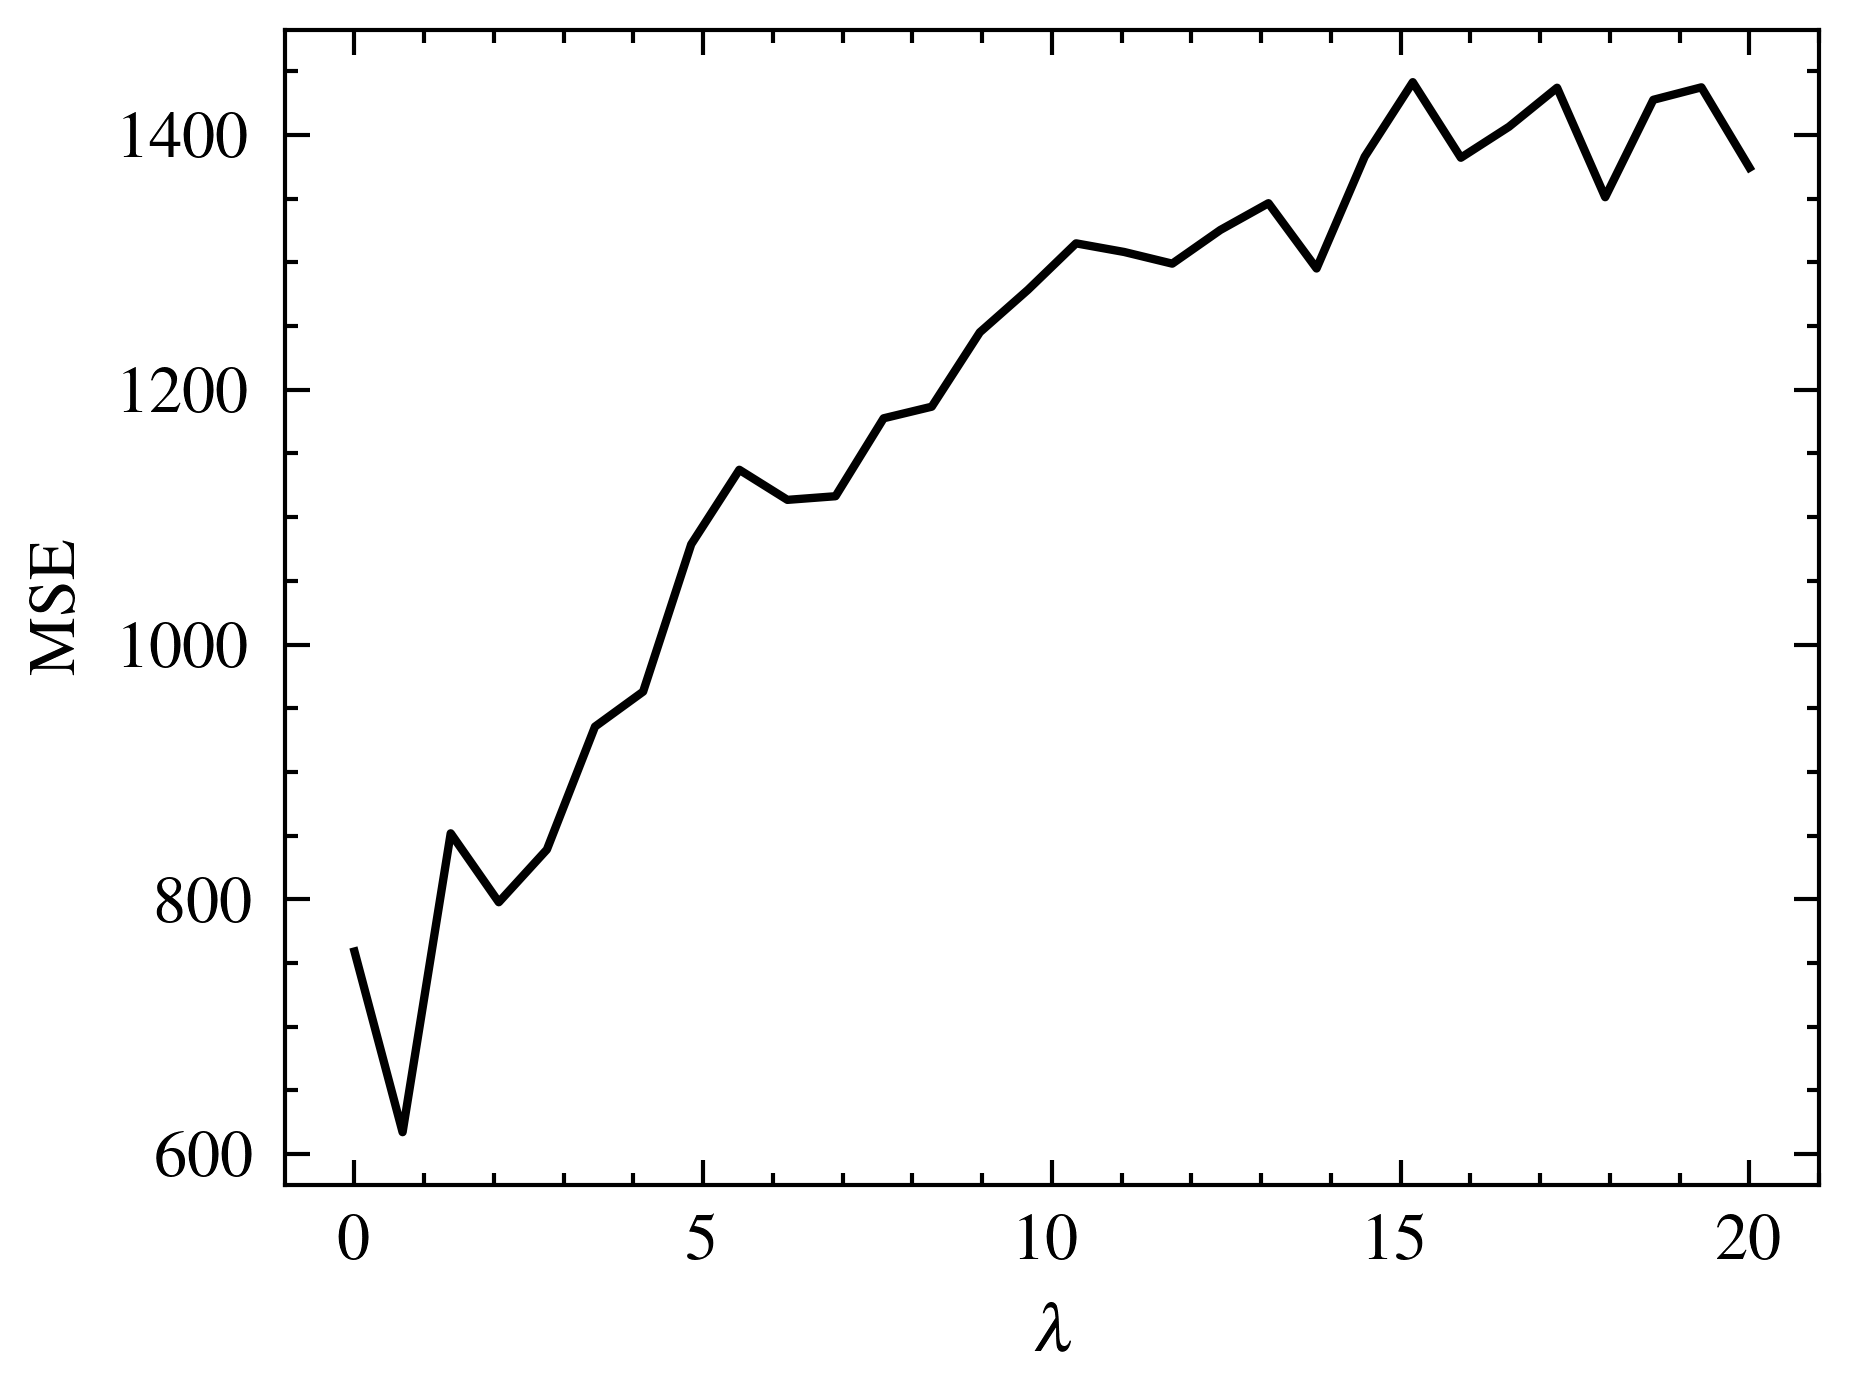

In [81]:
plt.figure()
plt.plot(lgrid, errors)
plt.xlabel(r'$\lambda$')
plt.ylabel('MSE')
# plt.savefig('ridge_lambdas.eps', format='eps')

In [82]:
lgrid[np.argmin(errors)]

0.6896551724137931

### We're keeping the model for lambda = 0.68

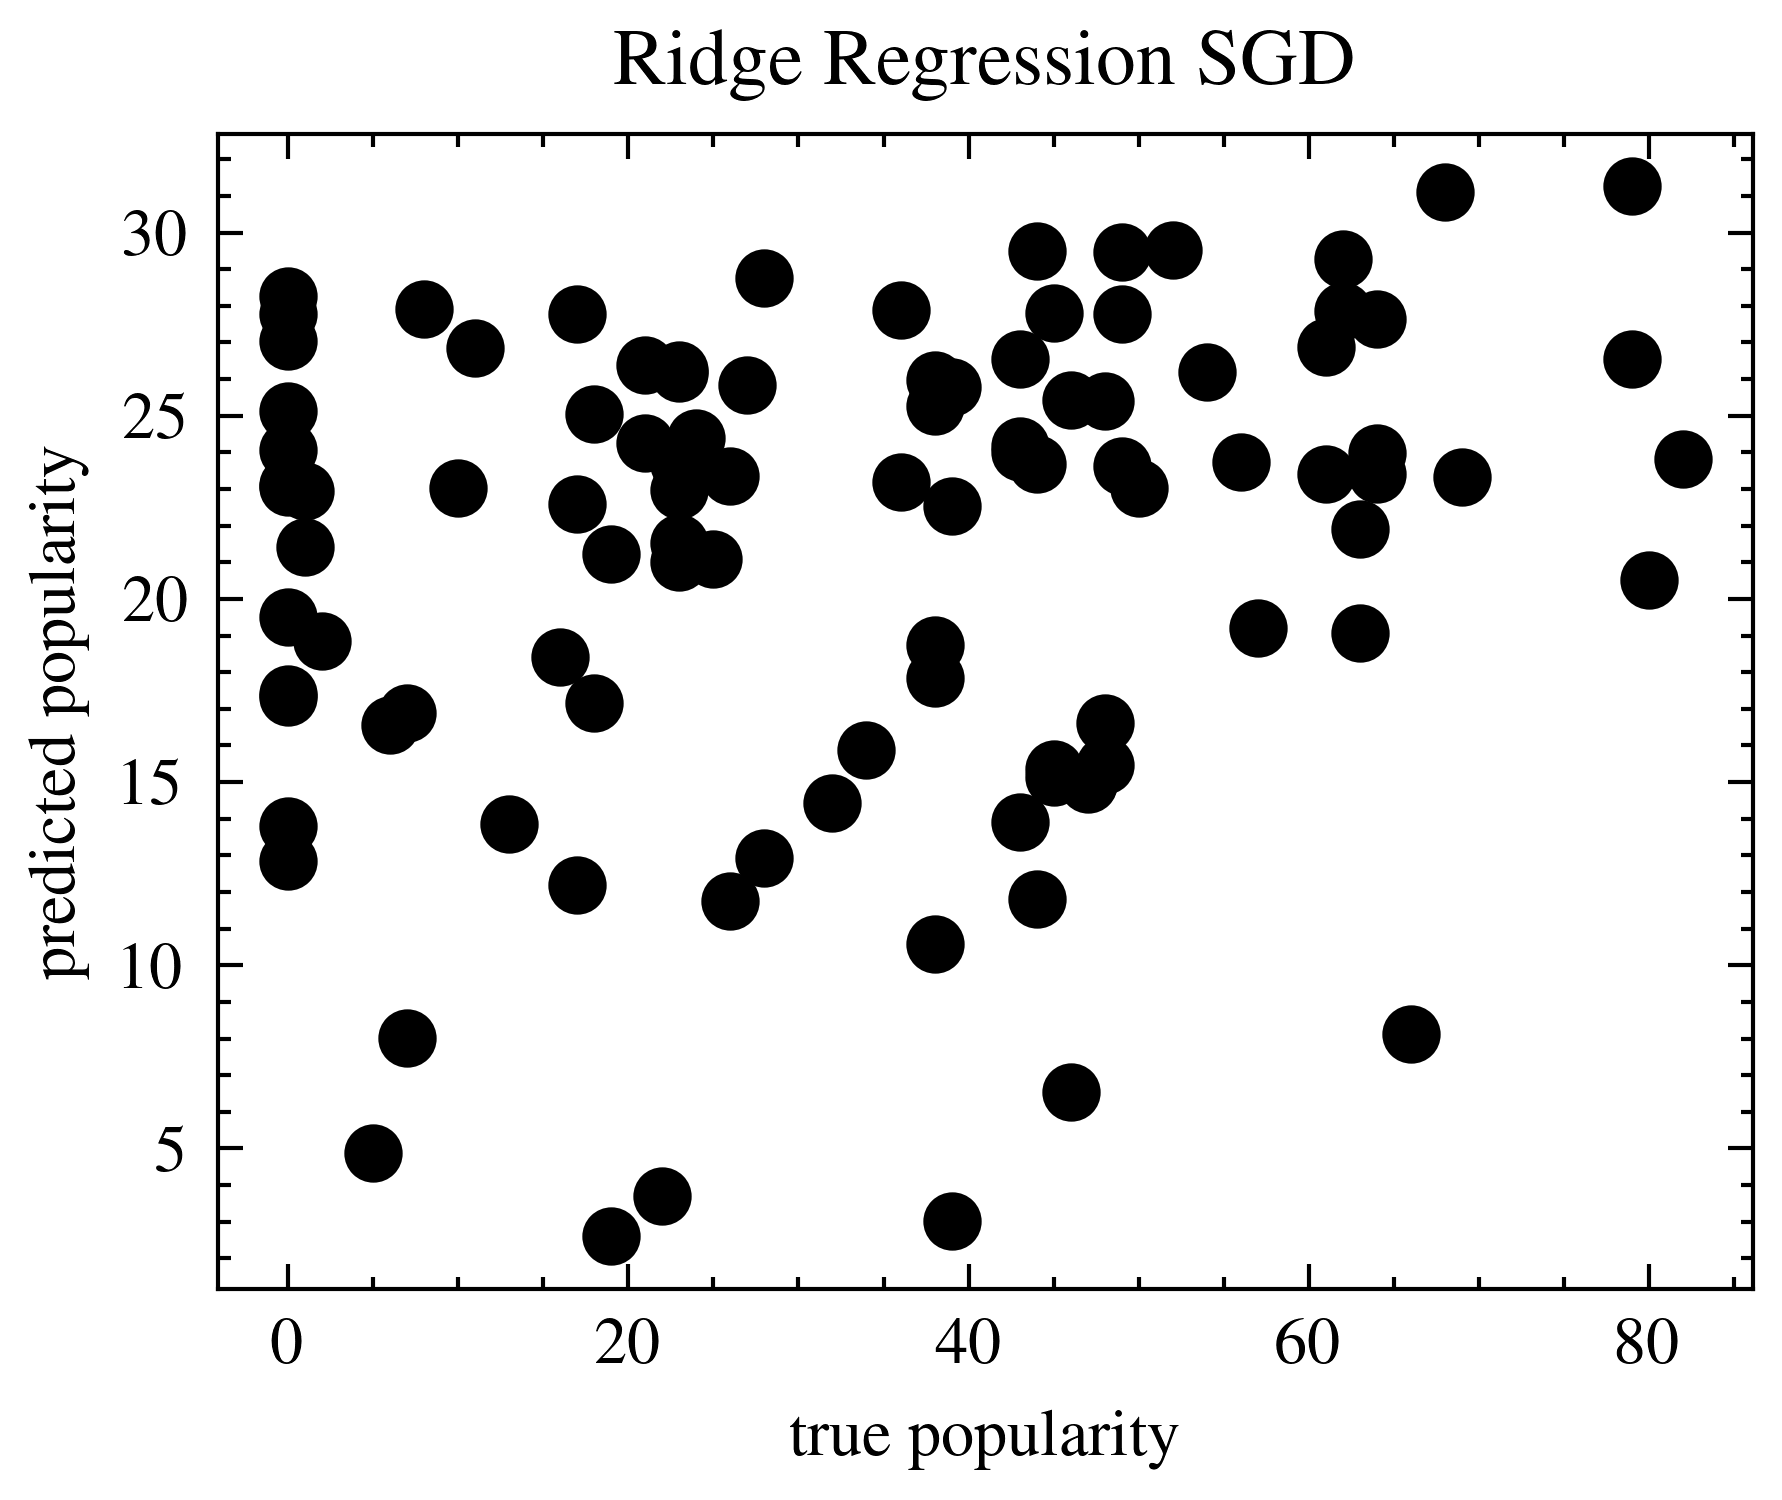

In [11]:
model = models.RidgeRegressionSGD(0.68, shape=X[0].shape[0])
model.train(X_train[:100000], y_train[:100000], n_epochs=100)
y_pred = model.predict(X_test)
plt.scatter(y_test[:100], y_pred[:100])
plt.xlabel('true popularity')
plt.ylabel('predicted popularity')
plt.title('Ridge Regression SGD')
plt.savefig('ridge-pred_num.eps', format='eps')
plt.show()

In [12]:
# Calculating the error:
model.compute_error(y_test, y_pred)

721.9114788251894

# We will now use all the features

## We need to encode the categorical variables before we can use them in the model

In [13]:
# Category columns:
cat = df.select_dtypes(include=['category', 'bool'])
df_full = pd.concat([df_num, cat], axis=1)
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114000 entries, 0 to 113999
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   duration_ms       114000 non-null  float64 
 1   danceability      114000 non-null  float64 
 2   energy            114000 non-null  float64 
 3   loudness          114000 non-null  float64 
 4   speechiness       114000 non-null  float64 
 5   acousticness      114000 non-null  float64 
 6   instrumentalness  114000 non-null  float64 
 7   liveness          114000 non-null  float64 
 8   valence           114000 non-null  float64 
 9   tempo             114000 non-null  float64 
 10  explicit          114000 non-null  bool    
 11  key               114000 non-null  category
 12  mode              114000 non-null  bool    
 13  time_signature    114000 non-null  category
 14  track_genre       114000 non-null  category
dtypes: bool(2), category(3), float64(10)
memory usage: 

Using one hot encoding for the categorical variables

In [14]:
df_full = pd.get_dummies(df_full, drop_first=True)

In [15]:
# Transform the boolean columns into 0 and 1
df_full['explicit'] = df_full['explicit'].astype(int)
df_full['mode'] = df_full['mode'].astype(int)
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114000 entries, 0 to 113999
Columns: 140 entries, duration_ms to track_genre_world-music
dtypes: float64(10), int64(2), uint8(128)
memory usage: 25.2 MB


In [16]:
# Doing the same steps as before
y = df['popularity'].values.reshape(-1)
X = df_full.values

In [17]:
n_X = []
t = np.array([1])
for i in range(len(X)):
    p = np.append(t, X[i])
    n_X.append(p)

X = np.array(n_X)

In [18]:
# Splitting data into train and test
n_samples = X.shape[0]
p = np.random.permutation(n_samples)
X_train = X[p[:int(0.8*n_samples)]]
y_train = y[p[:int(0.8*n_samples)]]
X_test = X[p[int(0.8*n_samples):]]
y_test = y[p[int(0.8*n_samples):]]

In [22]:
modelSGD = models.RidgeRegressionSGD(0.68, shape=X.shape[1])
erros = modelSGD.cross_validation(X_train[:10000], y_train[:10000], n_epochs=100, k=5)

In [23]:
print(f' The mean error is {np.mean(erros)}')

 The mean error is 594.9788214221371


In [76]:
modelSGD.compute_error(y_test, modelSGD.predict(X_test))

650.5564444421017

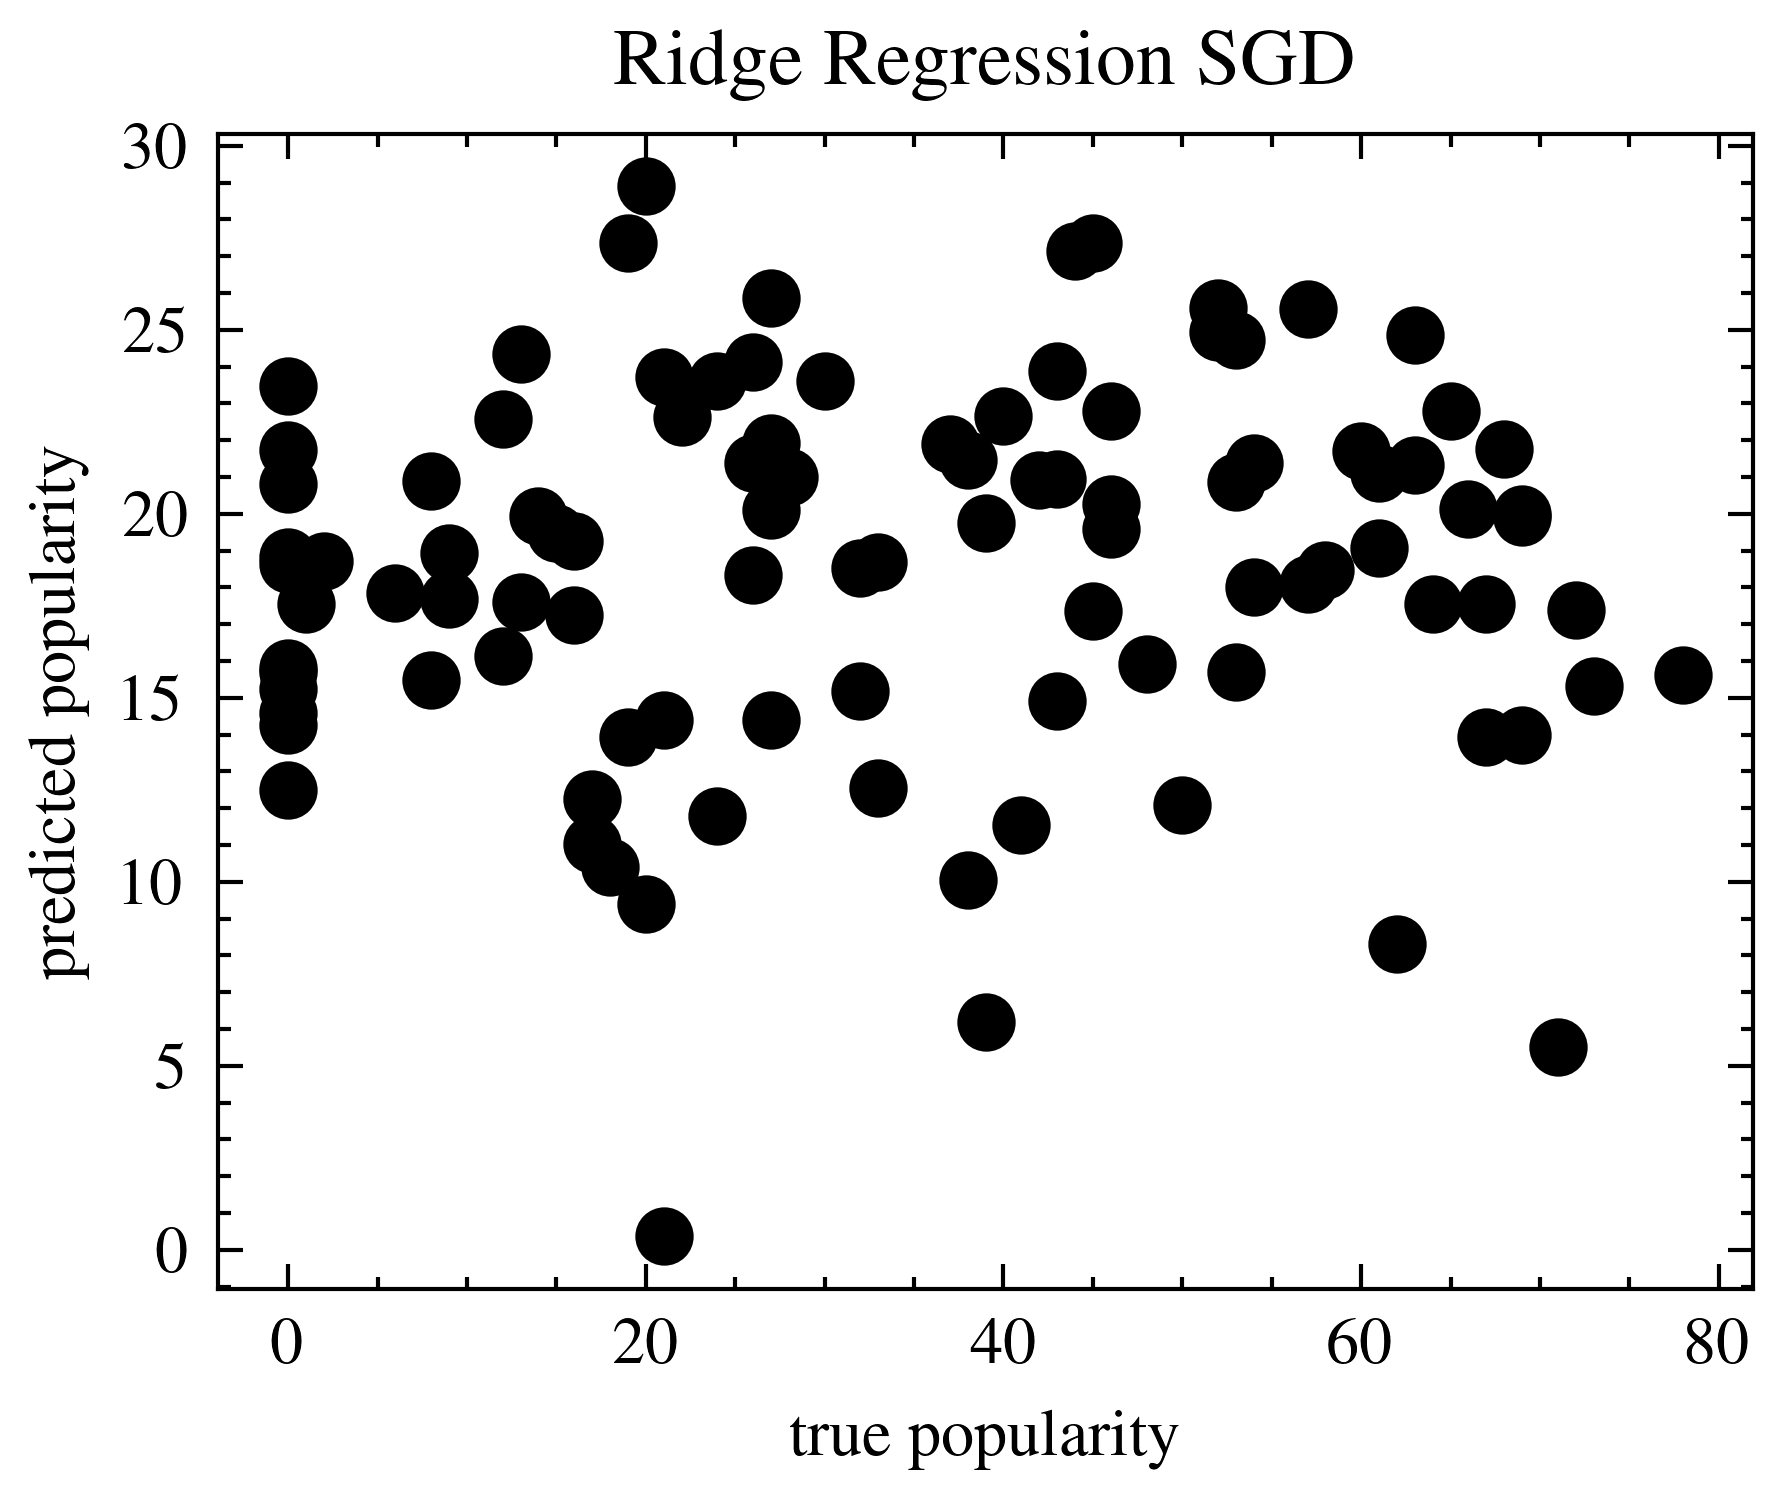

In [24]:
model = models.RidgeRegressionSGD(0.68, shape=X[0].shape[0])
model.train(X_train[:10000], y_train[:10000], n_epochs=100)
y_pred = model.predict(X_test)
plt.scatter(y_test[:100], y_pred[:100])
plt.xlabel('true popularity')
plt.ylabel('predicted popularity')
plt.title('Ridge Regression SGD')
plt.savefig('ridge-pred_cat.eps', format='eps')
plt.show()